### Truncated Incremental k-DPP

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dpp import QualityMapClass,kdpp,ikdpp,add_colorbar
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print ("Packages loaded.")

Packages loaded.


### Get measurements

In [3]:
np.random.seed(seed=0)
n_total           = 2000
n_select          = 100
hyp               = {'g':1.0,'l':0.1}
QM                = QualityMapClass()
xs_total,qs_total = QM.get_meas(n_meas=n_total)
print ("n_total:[%d] n_select:[%d] "%(n_total,n_select))

n_total:[2000] n_select:[100] 


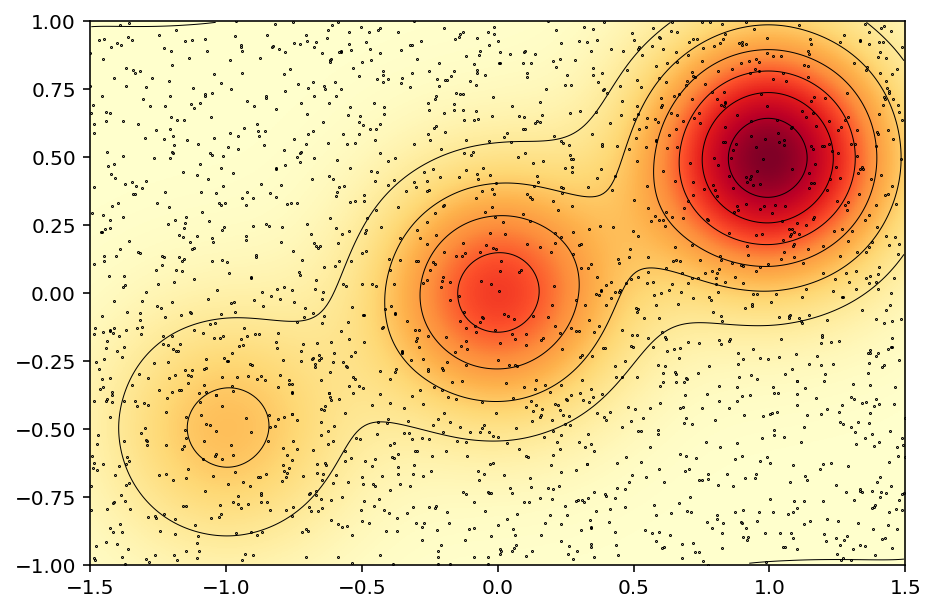

In [6]:
plt.figure(figsize = (10,5))
plt.rcParams.update({'font.size':10})
im = plt.imshow(X      = QM.Q,
                extent = QM.axis_info,
                cmap   = 'YlOrRd',
                origin = 'lower')
plt.contour(QM.Q,
            extent     = QM.axis_info,
            origin     = 'lower',
            colors     = 'k',
            linewidths = 1/2)
plt.plot(xs_total[:,0],xs_total[:,1],'.',mfc='none',mec='k',ms=1,lw=1/2)
plt.show()

### Run DPP

In [6]:
# Original k-DPP (without Q)
np.random.seed(seed=0)
tic = datetime.now()
xs_kdpp_woq,idxs_kdpp_woq = kdpp(
    xs_total = xs_total,
    qs_total = None,
    n_select = n_select,
    hyp      = hyp)
toc_kdpp_woq = (datetime.now()-tic).total_seconds()
print ("Original k-DPP without Q took [%.3f] second"%(toc_kdpp_woq))

Original k-DPP without Q took [10.412] second


In [7]:
# Original k-DPP (with Q)
np.random.seed(seed=0)
tic = datetime.now()
xs_kdpp_wq,idxs_kdpp_wq = kdpp(
    xs_total = xs_total,
    qs_total = qs_total,
    n_select = n_select,
    hyp      = hyp)
toc_kdpp_wq = (datetime.now()-tic).total_seconds()
print ("Original k-DPP with Q took [%.3f] second"%(toc_kdpp_wq))

Original k-DPP with Q took [11.885] second


In [10]:
# Incremental k-DPP (without Q)
np.random.seed(seed=0)
tic = datetime.now()
xs_ikdpp_woq,idxs_ikdpp_woq = ikdpp(
    xs_total = xs_total,
    qs_total = None,
    n_select = n_select,
    hyp      = hyp)
toc_ikdpp_woq = (datetime.now()-tic).total_seconds()
print ("Incremental k-DPP without Q took [%.3f] second"%(toc_ikdpp_woq))

Incremental k-DPP without Q took [2.114] second


In [11]:
# Incremental k-DPP (with Q)
np.random.seed(seed=0)
tic = datetime.now()
xs_ikdpp_wq,idxs_ikdpp_wq = ikdpp(
    xs_total = xs_total,
    qs_total = qs_total,
    n_select = n_select,
    hyp      = hyp)
toc = (datetime.now()-tic).total_seconds()
print ("Incremental k-DPP with Q took [%.3f] second"%(toc))

Incremental k-DPP with Q took [2.347] second


In [17]:
# Truncated Incremental k-DPP (without Q)
np.random.seed(seed=0)
tic = datetime.now()
xs_tikdpp_woq,idxs_tikdpp_woq = ikdpp(
    xs_total = xs_total,
    qs_total = None,
    n_select = n_select,
    n_trunc  = 50,
    hyp      = hyp)
toc_tikdpp_woq = (datetime.now()-tic).total_seconds()
print ("Truncated Incremental k-DPP took [%.3f] second"%(toc_tikdpp_woq))

Truncated Incremental k-DPP took [0.105] second


In [18]:
# Truncated Incremental k-DPP (with Q)
np.random.seed(seed=0)
tic = datetime.now()
xs_tikdpp_wq,idxs_tikdpp_wq = ikdpp(
    xs_total = xs_total,
    qs_total = qs_total,
    n_select = n_select,
    n_trunc  = 50,
    hyp      = hyp)
toc_tikdpp_wq = (datetime.now()-tic).total_seconds()
print ("Truncated Incremental k-DPP took [%.3f] second"%(toc_tikdpp_wq))

Truncated Incremental k-DPP took [0.099] second


### Print

In [20]:
print ("n_total:[%d] n_select:[%d] "%(n_total,n_select))
print ("Original k-DPP without Q took [%.3f] second"%(toc_kdpp_woq))
print ("Original k-DPP with Q took [%.3f] second"%(toc_kdpp_wq))
print ("Incremental k-DPP without Q took [%.3f] second"%(toc_ikdpp_woq))
print ("Incremental k-DPP with Q took [%.3f] second"%(toc))
print ("Truncated Incremental k-DPP took [%.3f] second"%(toc_tikdpp_woq))
print ("Truncated Incremental k-DPP took [%.3f] second"%(toc_tikdpp_wq))

n_total:[2000] n_select:[100] 
Original k-DPP without Q took [10.412] second
Original k-DPP with Q took [11.885] second
Incremental k-DPP without Q took [2.114] second
Incremental k-DPP with Q took [2.347] second
Truncated Incremental k-DPP took [0.105] second
Truncated Incremental k-DPP took [0.099] second


### Plot

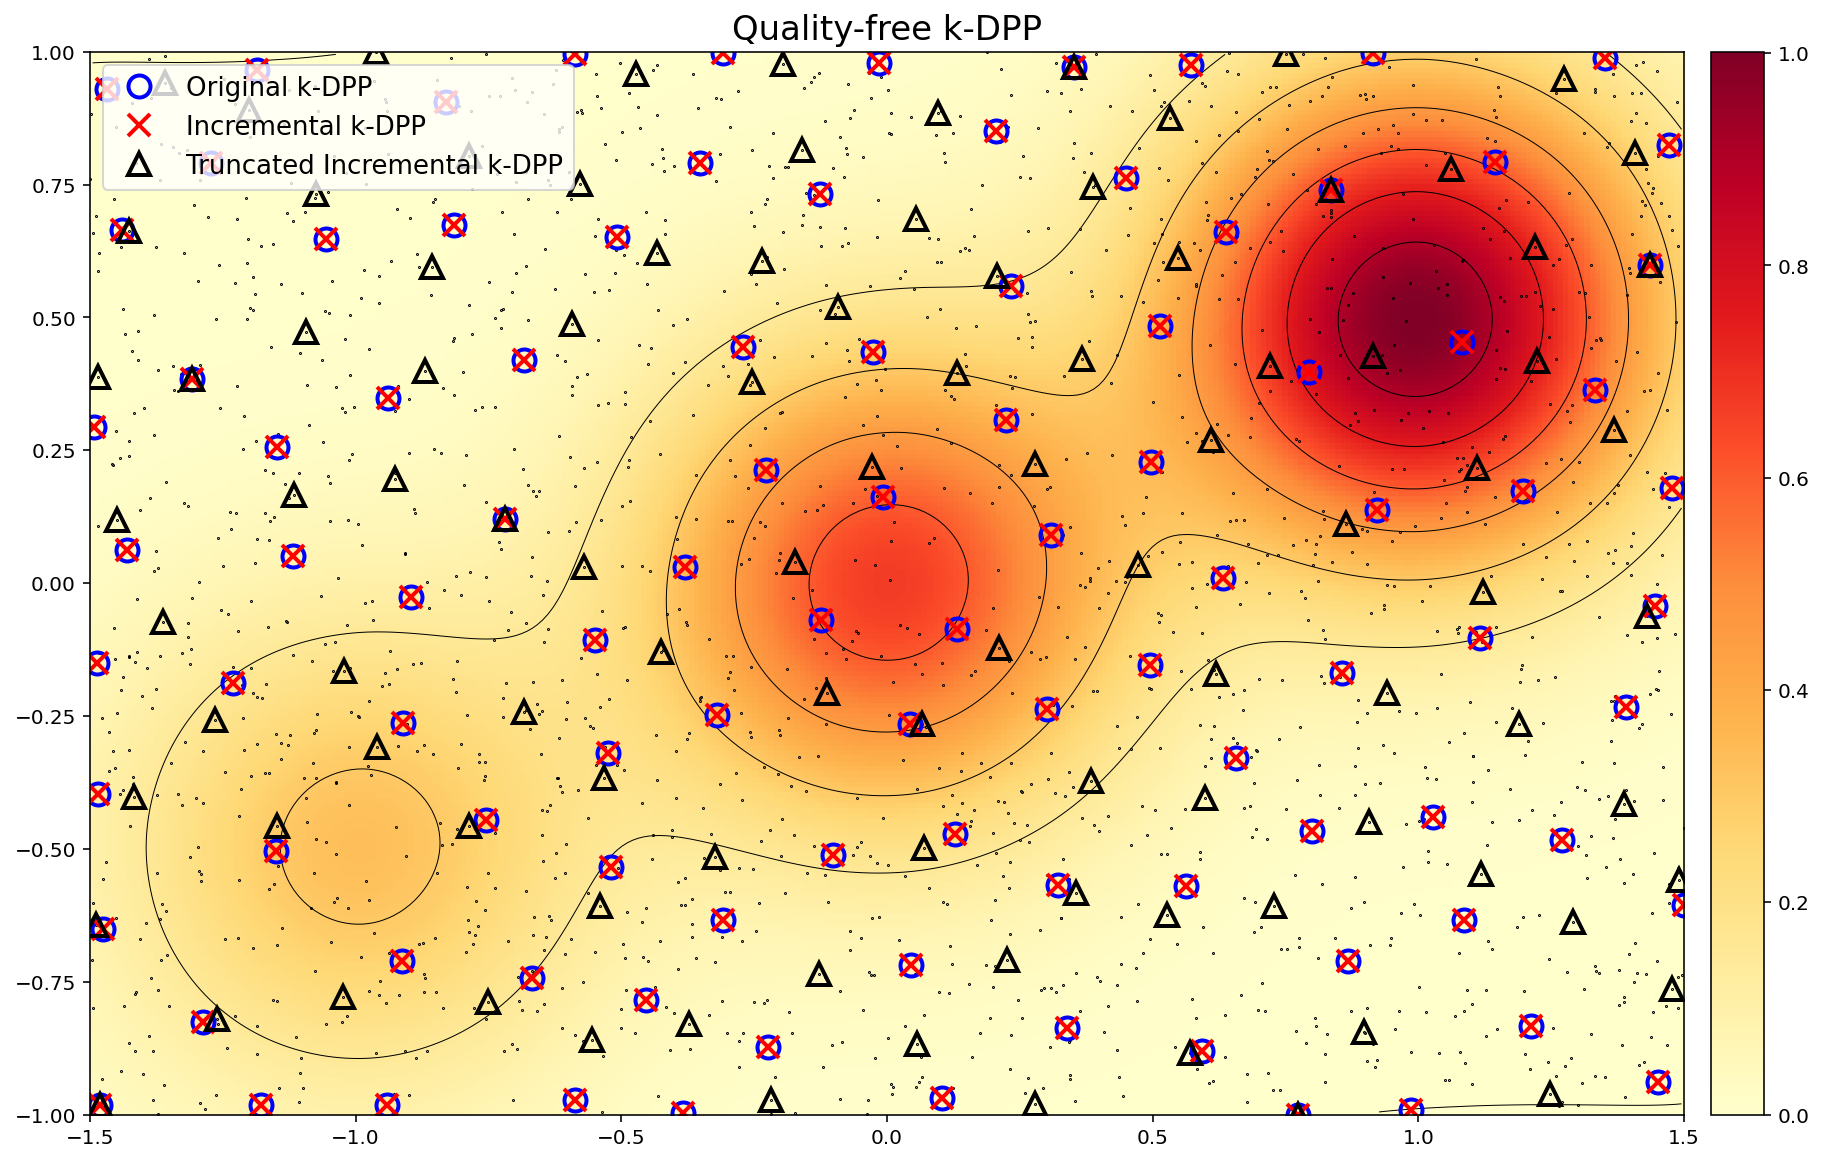

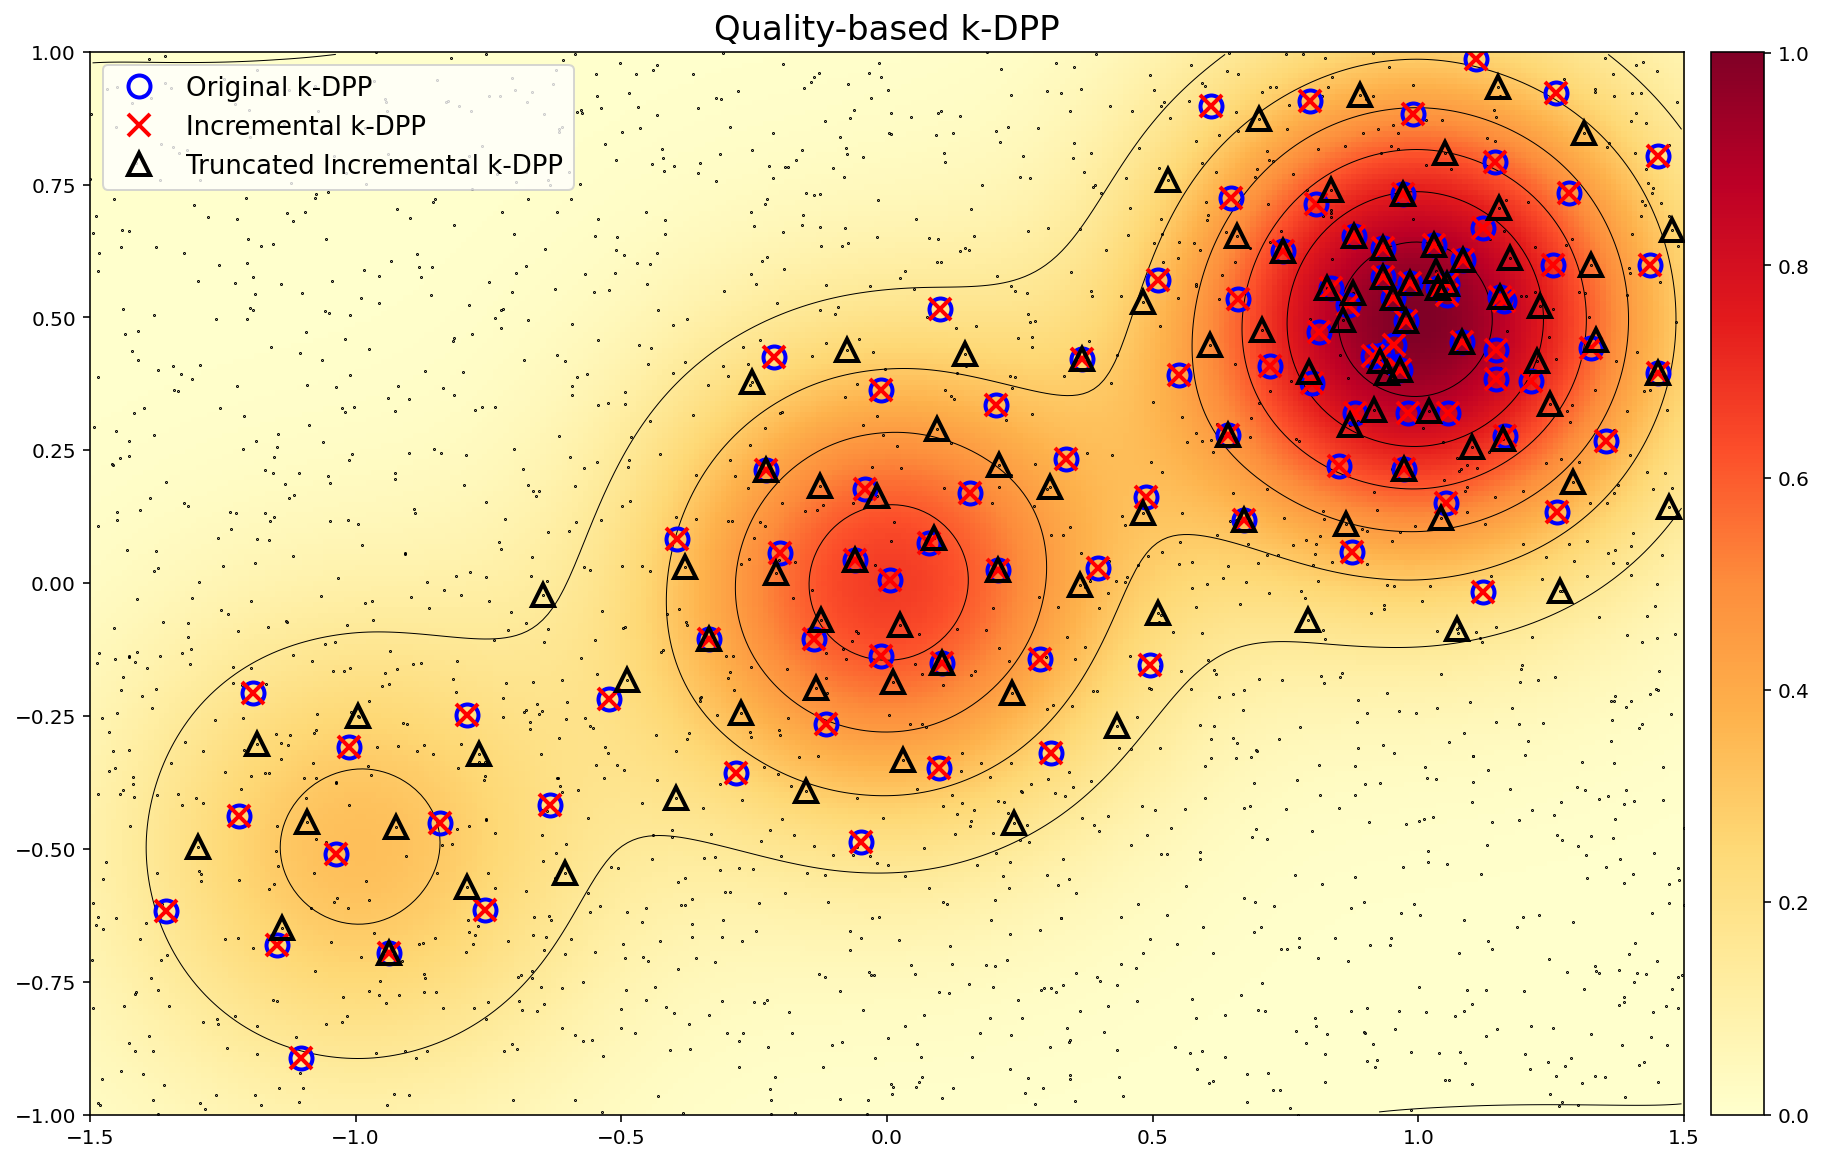

In [21]:
# Plot Quality-free DPP              
plt.figure(figsize = (15,10))
plt.rcParams.update({'font.size':10})
im = plt.imshow(X      = QM.Q,
                extent = QM.axis_info,
                cmap   = 'YlOrRd',
                origin = 'lower')
plt.contour(QM.Q,
            extent     = QM.axis_info,
            origin     = 'lower',
            colors     = 'k',
            linewidths = 1/2)
plt.plot(xs_total[:,0],xs_total[:,1],'.',mfc='none',mec='k',ms=1,lw=1/2)
plt.plot(xs_kdpp_woq[:,0],xs_kdpp_woq[:,1],'o',ms=11,mfc='None',mec='b',
         markeredgewidth=2.0,label='Original k-DPP')
plt.plot(xs_ikdpp_woq[:,0],xs_ikdpp_woq[:,1],'x',ms=11,mfc='None',mec='r',
         markeredgewidth=2.0,label='Incremental k-DPP')
plt.plot(xs_tikdpp_woq[:,0],xs_tikdpp_woq[:,1],'^',ms=11,mfc='None',mec='k',
         markeredgewidth=2.0,label='Truncated Incremental k-DPP')
plt.title("Quality-free k-DPP",fontsize=17)
plt.legend(fontsize=13,loc='upper left')
add_colorbar(im); plt.axis(QM.axis_info); plt.axis('equal'); 
plt.show()

# Plot Quality-incorporated DPP              
plt.figure(figsize = (15,10))
plt.rcParams.update({'font.size':10})
im = plt.imshow(X      = QM.Q,
                extent = QM.axis_info,
                cmap   = 'YlOrRd',
                origin = 'lower')
plt.contour(QM.Q,
            extent     = QM.axis_info,
            origin     = 'lower',
            colors     = 'k',
            linewidths = 1/2)
plt.plot(xs_total[:,0],xs_total[:,1],'.',mfc='none',mec='k',ms=1,lw=1/2)
plt.plot(xs_kdpp_wq[:,0],xs_kdpp_wq[:,1],'o',ms=11,mfc='None',mec='b',
         markeredgewidth=2.0,label='Original k-DPP')
plt.plot(xs_ikdpp_wq[:,0],xs_ikdpp_wq[:,1],'x',ms=11,mfc='None',mec='r',
         markeredgewidth=2.0,label='Incremental k-DPP')
plt.plot(xs_tikdpp_wq[:,0],xs_tikdpp_wq[:,1],'^',ms=11,mfc='None',mec='k',
         markeredgewidth=2.0,label='Truncated Incremental k-DPP')
plt.title("Quality-based k-DPP",fontsize=17)
plt.legend(fontsize=13,loc='upper left')
add_colorbar(im); plt.axis(QM.axis_info); plt.axis('equal'); 
plt.show()